In [1]:
import os
import pandas as pd
import numpy as np
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
csv_dir = '../../SEC Trackman Data/'
all_files = [os.path.join(csv_dir, f) for f in os.listdir(csv_dir) if f.endswith('.csv')]

df_list = []

for file in all_files:
    df = pd.read_csv(file)
    df_list.append(df)

all_pitches = pd.concat(df_list, ignore_index=True)

print(all_pitches.shape)
print(all_pitches.columns)

(270589, 167)
Index(['PitchNo', 'Date', 'Time', 'PAofInning', 'PitchofPA', 'Pitcher',
       'PitcherId', 'PitcherThrows', 'PitcherTeam', 'Batter',
       ...
       'ThrowTrajectoryZc1', 'ThrowTrajectoryZc2', 'PitchReleaseConfidence',
       'PitchLocationConfidence', 'PitchMovementConfidence',
       'HitLaunchConfidence', 'HitLandingConfidence',
       'CatcherThrowCatchConfidence', 'CatcherThrowReleaseConfidence',
       'CatcherThrowLocationConfidence'],
      dtype='object', length=167)


In [3]:
ffs = all_pitches[all_pitches['TaggedPitchType'].isin(['FourSeamFastBall', 'Fastball'])]
print(ffs.shape)

(125719, 167)


In [4]:
ffs['whiff'] = np.where(ffs['PitchCall']=='StrikeSwinging',1,0)

/tmp/ipykernel_19284/3136182571.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffs['whiff'] = np.where(ffs['PitchCall']=='StrikeSwinging',1,0)


In [5]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [6]:
ffs_X = ffs[preds]
ffs_y = ffs['whiff']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(ffs_X, ffs_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.82%


In [8]:
aub_ffs = ffs[ffs['PitcherTeam']=='AUB_TIG']

In [9]:
# Get unique values
unique_values = ffs['Pitcher'].unique()
aub_unique_values = aub_ffs['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: ffs[ffs['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: ffs[ffs['Pitcher'] == value] for value in aub_unique_values}

['Herberholz, Christian' 'Nelson, Drew' 'Horne, Trevor' 'Olson, Ryan'
 'Carlson, Parker' 'Keshock, Cameron' 'Armstrong, John' 'Vail, Tommy'
 'Bauman, Tanner' 'Cannon, Will' 'Myers, Carson' 'Tilly, Cameron'
 'Allsup, Chase' 'McBride, Connor' 'Isbell, Chase' 'Murphy, Hayden'
 'Graves, Griffin' 'Watts, Dylan' 'Crotchfelt, Zach' 'Copeland, Konner'
 'Petrovic, Alexander' 'Schorr, Ben' 'Gonzalez, Joseph' 'Sheehan, Tommy']


In [10]:
def aub_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} Four Seam stuff+: {np.mean(stuff * 100)}")

In [11]:
for pitcher in aub_unique_values:
    aub_ffs_stuff(pitcher)

Herberholz, Christian Four Seam stuff+: 105.56941223144531
Nelson, Drew Four Seam stuff+: 95.07010650634766
Horne, Trevor Four Seam stuff+: 102.4990234375
Olson, Ryan Four Seam stuff+: 53.18757247924805
Carlson, Parker Four Seam stuff+: 80.93983459472656
Keshock, Cameron Four Seam stuff+: 76.22998046875
Armstrong, John Four Seam stuff+: 85.54305267333984
Vail, Tommy Four Seam stuff+: 186.03330993652344
Bauman, Tanner Four Seam stuff+: 72.12655639648438
Cannon, Will Four Seam stuff+: 110.87004089355469
Myers, Carson Four Seam stuff+: 71.81211853027344
Tilly, Cameron Four Seam stuff+: 108.04875183105469
Allsup, Chase Four Seam stuff+: 135.01699829101562
McBride, Connor Four Seam stuff+: 120.2344741821289
Isbell, Chase Four Seam stuff+: 82.7505111694336
Murphy, Hayden Four Seam stuff+: 90.80268096923828
Graves, Griffin Four Seam stuff+: 143.97718811035156
Watts, Dylan Four Seam stuff+: 84.56826782226562
Crotchfelt, Zach Four Seam stuff+: 135.53079223632812
Copeland, Konner Four Seam stuff

In [ ]:
aub_subsets['Keplinger, Konner']

In [12]:
import joblib

joblib.dump(model, '../../models/fourseam_all_model.pkl')

['../../models/fourseam_all_model.pkl']

In [13]:
ffs_rr = ffs[(ffs['PitcherThrows'] == 'Right') & (ffs['BatterSide'] == 'Right')]
ffs_rl = ffs[(ffs['PitcherThrows'] == 'Right') & (ffs['BatterSide'] == 'Left')]
ffs_lr = ffs[(ffs['PitcherThrows'] == 'Left') & (ffs['BatterSide'] == 'Right')]
ffs_ll = ffs[(ffs['PitcherThrows'] == 'Left') & (ffs['BatterSide'] == 'Left')]

print(ffs_rr.shape)
print(ffs_rl.shape)
print(ffs_lr.shape)
print(ffs_ll.shape)

(47555, 168)
(36801, 168)
(26799, 168)
(14427, 168)


In [14]:
ffs_rr['whiff'] = np.where(ffs_rr['PitchCall']=='StrikeSwinging',1,0)
ffs_rl['whiff'] = np.where(ffs_rl['PitchCall']=='StrikeSwinging',1,0)
ffs_lr['whiff'] = np.where(ffs_lr['PitchCall']=='StrikeSwinging',1,0)
ffs_ll['whiff'] = np.where(ffs_ll['PitchCall']=='StrikeSwinging',1,0)

/tmp/ipykernel_19284/2915248739.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffs_rr['whiff'] = np.where(ffs_rr['PitchCall']=='StrikeSwinging',1,0)
/tmp/ipykernel_19284/2915248739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ffs_rl['whiff'] = np.where(ffs_rl['PitchCall']=='StrikeSwinging',1,0)
/tmp/ipykernel_19284/2915248739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

In [15]:
preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']

In [16]:
ffs_rr_X = ffs_rr[preds]
ffs_rr_y = ffs_rr['whiff']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(ffs_rr_X, ffs_rr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.89%


In [19]:
import joblib

joblib.dump(model, '../../models/fourseam_rr_model.pkl')

['../../models/fourseam_rr_model.pkl']

ROC AUC: 0.5088


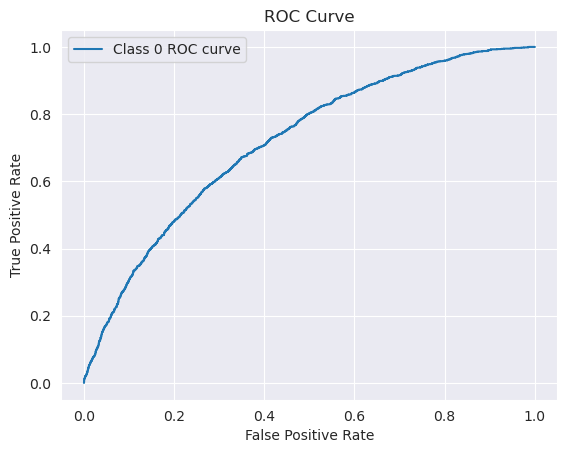

In [18]:
y_pred_prob = model.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, predictions, multi_class='ovr')

print(f'ROC AUC: {roc_auc:.4f}')

# Plotting ROC Curve for one class (e.g., class 0)
fpr, tpr, _ = roc_curve(y_test == 1, y_pred_prob)
plt.plot(fpr, tpr, label='Class 0 ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

In [20]:
aub_ffs_rr = ffs_rr[ffs_rr['PitcherTeam']=='AUB_TIG']
print(aub_ffs_rr.shape)

(2400, 168)


In [21]:
# Get unique values
unique_values = ffs_rr['Pitcher'].unique()
aub_unique_values = aub_ffs_rr['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: ffs_rr[ffs_rr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: ffs_rr[ffs_rr['Pitcher'] == value] for value in aub_unique_values}

['Herberholz, Christian' 'Horne, Trevor' 'Olson, Ryan' 'Carlson, Parker'
 'Keshock, Cameron' 'Armstrong, John' 'Cannon, Will' 'Tilly, Cameron'
 'Allsup, Chase' 'McBride, Connor' 'Isbell, Chase' 'Murphy, Hayden'
 'Watts, Dylan' 'Petrovic, Alexander' 'Gonzalez, Joseph' 'Schorr, Ben']


In [22]:
def aub_rr_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_rr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} RR Four Seam stuff+: {np.mean(stuff * 100)}")

In [23]:
for pitcher in aub_unique_values:
    aub_rr_ffs_stuff(pitcher)

Herberholz, Christian RR Four Seam stuff+: 89.30109405517578
Horne, Trevor RR Four Seam stuff+: 122.75839233398438
Olson, Ryan RR Four Seam stuff+: 83.78729248046875
Carlson, Parker RR Four Seam stuff+: 68.20626831054688
Keshock, Cameron RR Four Seam stuff+: 158.83114624023438
Armstrong, John RR Four Seam stuff+: 70.21876525878906
Cannon, Will RR Four Seam stuff+: 95.5855484008789
Tilly, Cameron RR Four Seam stuff+: 107.64210510253906
Allsup, Chase RR Four Seam stuff+: 130.3473663330078
McBride, Connor RR Four Seam stuff+: 87.9650650024414
Isbell, Chase RR Four Seam stuff+: 71.78107452392578
Murphy, Hayden RR Four Seam stuff+: 73.97808837890625
Watts, Dylan RR Four Seam stuff+: 95.52584838867188
Petrovic, Alexander RR Four Seam stuff+: 51.7245979309082
Gonzalez, Joseph RR Four Seam stuff+: 96.84825897216797
Schorr, Ben RR Four Seam stuff+: 47.51643753051758


In [24]:
ffs_rl_X = ffs_rl[preds]
ffs_rl_y = ffs_rl['whiff']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(ffs_rl_X, ffs_rl_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.61%


In [30]:
import joblib

joblib.dump(model, '../../models/fourseam_rl_model.pkl')

['../../models/fourseam_rl_model.pkl']

In [26]:
aub_ffs_rl = ffs_rl[ffs_rl['PitcherTeam']=='AUB_TIG']
print(aub_ffs_rl.shape)

(1882, 168)


In [27]:
# Get unique values
unique_values = ffs_rl['Pitcher'].unique()
aub_unique_values = aub_ffs_rl['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: ffs_rl[ffs_rl['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: ffs_rl[ffs_rl['Pitcher'] == value] for value in aub_unique_values}

['Herberholz, Christian' 'Horne, Trevor' 'Olson, Ryan' 'Keshock, Cameron'
 'Armstrong, John' 'Cannon, Will' 'Tilly, Cameron' 'Allsup, Chase'
 'Isbell, Chase' 'Murphy, Hayden' 'McBride, Connor' 'Carlson, Parker'
 'Watts, Dylan' 'Petrovic, Alexander' 'Schorr, Ben' 'Gonzalez, Joseph']


In [28]:
def aub_rl_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_rl_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} Four Seam RL stuff+: {np.mean(stuff * 100)}")

In [29]:
for pitcher in aub_unique_values:
    aub_rl_ffs_stuff(pitcher)

Herberholz, Christian Four Seam RL stuff+: 105.1431884765625
Horne, Trevor Four Seam RL stuff+: 65.89749908447266
Olson, Ryan Four Seam RL stuff+: 43.44674301147461
Keshock, Cameron Four Seam RL stuff+: 24.23225212097168
Armstrong, John Four Seam RL stuff+: 80.32503509521484
Cannon, Will Four Seam RL stuff+: 116.99591064453125
Tilly, Cameron Four Seam RL stuff+: 90.81563568115234
Allsup, Chase Four Seam RL stuff+: 157.75059509277344
Isbell, Chase Four Seam RL stuff+: 72.34778594970703
Murphy, Hayden Four Seam RL stuff+: 116.97882080078125
McBride, Connor Four Seam RL stuff+: 160.82774353027344
Carlson, Parker Four Seam RL stuff+: 73.26499938964844
Watts, Dylan Four Seam RL stuff+: 115.4656982421875
Petrovic, Alexander Four Seam RL stuff+: 125.4988784790039
Schorr, Ben Four Seam RL stuff+: 52.860572814941406
Gonzalez, Joseph Four Seam RL stuff+: 57.584468841552734


In [31]:
ffs_lr_X = ffs_lr[preds]
ffs_lr_y = ffs_lr['whiff']

In [32]:
X_train, X_test, y_train, y_test = train_test_split(ffs_lr_X, ffs_lr_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.28%


In [33]:
import joblib

joblib.dump(model, '../../models/fourseam_lr_model.pkl')

['../../models/fourseam_lr_model.pkl']

In [34]:
aub_ffs_lr = ffs_lr[ffs_lr['PitcherTeam']=='AUB_TIG']
print(aub_ffs_lr.shape)

(1651, 168)


In [35]:
# Get unique values
unique_values = ffs_lr['Pitcher'].unique()
aub_unique_values = aub_ffs_lr['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: ffs_lr[ffs_lr['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: ffs_lr[ffs_lr['Pitcher'] == value] for value in aub_unique_values}

['Nelson, Drew' 'Vail, Tommy' 'Bauman, Tanner' 'Myers, Carson'
 'Graves, Griffin' 'Crotchfelt, Zach' 'Copeland, Konner' 'Sheehan, Tommy'
 'Murphy, Hayden']


In [36]:
def aub_lr_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_lr_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} Four Seam LR stuff+: {np.mean(stuff * 100)}")

In [37]:
for pitcher in aub_unique_values:
    aub_lr_ffs_stuff(pitcher)

Nelson, Drew Four Seam LR stuff+: 100.18602752685547
Vail, Tommy Four Seam LR stuff+: 180.4160919189453
Bauman, Tanner Four Seam LR stuff+: 89.64679718017578
Myers, Carson Four Seam LR stuff+: 71.73851013183594
Graves, Griffin Four Seam LR stuff+: 84.99886322021484
Crotchfelt, Zach Four Seam LR stuff+: 127.01658630371094
Copeland, Konner Four Seam LR stuff+: 75.27986907958984
Sheehan, Tommy Four Seam LR stuff+: 48.4864616394043
Murphy, Hayden Four Seam LR stuff+: 52.61192321777344


In [39]:
ffs_ll_X = ffs_ll[preds]
ffs_ll_y = ffs_ll['whiff']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(ffs_ll_X, ffs_ll_y, test_size=.33, random_state=25)

model = XGBClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 91.26%


In [41]:
import joblib

joblib.dump(model, '../../models/fourseam_ll_model.pkl')

['../../models/fourseam_ll_model.pkl']

In [42]:
aub_ffs_ll = ffs_ll[ffs_ll['PitcherTeam']=='AUB_TIG']
print(aub_ffs_ll.shape)

(813, 168)


In [43]:
# Get unique values
unique_values = ffs_ll['Pitcher'].unique()
aub_unique_values = aub_ffs_ll['Pitcher'].unique()

print(aub_unique_values)

# Create a dictionary to store subsets
all_subsets = {value: ffs_ll[ffs_ll['Pitcher'] == value] for value in unique_values}

aub_subsets = {value: ffs_ll[ffs_ll['Pitcher'] == value] for value in aub_unique_values}

['Nelson, Drew' 'Vail, Tommy' 'Bauman, Tanner' 'Myers, Carson'
 'Graves, Griffin' 'Copeland, Konner' 'Sheehan, Tommy' 'Crotchfelt, Zach']


In [44]:
def aub_ll_ffs_stuff(name):
    
    preds = ['RelSpeed','VertRelAngle','HorzRelAngle','SpinRate','SpinAxis','RelHeight','RelSide','Extension','VertBreak','InducedVertBreak','HorzBreak','ZoneSpeed','VertApprAngle','HorzApprAngle','ZoneTime','pfxx','pfxz','x0','y0','z0','vx0','vy0','vz0','ax0','ay0','az0','SpeedDrop','PitchTrajectoryXc1','PitchTrajectoryXc2','PitchTrajectoryYc0','PitchTrajectoryYc1','PitchTrajectoryYc2','PitchTrajectoryZc0','PitchTrajectoryZc1','PitchTrajectoryZc2']
    
    all_preds = model.predict_proba(ffs_ll_X)[:,1]
    mean_pred = np.mean(all_preds)

    pitcher = aub_subsets[name]
    pitcher_x = pitcher[preds]

    whiff_preds = model.predict_proba(pitcher_x)[:,1]

    stuff = whiff_preds/mean_pred
    
    print(f"{name} Four Seam LL stuff+: {np.mean(stuff * 100)}")

In [45]:
for pitcher in aub_unique_values:
    aub_ll_ffs_stuff(pitcher)

Nelson, Drew Four Seam LL stuff+: 125.9273681640625
Vail, Tommy Four Seam LL stuff+: 172.6954345703125
Bauman, Tanner Four Seam LL stuff+: 47.41603469848633
Myers, Carson Four Seam LL stuff+: 46.49747848510742
Graves, Griffin Four Seam LL stuff+: 317.50457763671875
Copeland, Konner Four Seam LL stuff+: 142.1805877685547
Sheehan, Tommy Four Seam LL stuff+: 29.153879165649414
Crotchfelt, Zach Four Seam LL stuff+: 79.48432922363281


In [46]:
aub_subsets['Vail, Tommy']

,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,Batter,...,ThrowTrajectoryZc2,PitchReleaseConfidence,PitchLocationConfidence,PitchMovementConfidence,HitLaunchConfidence,HitLandingConfidence,CatcherThrowCatchConfidence,CatcherThrowReleaseConfidence,CatcherThrowLocationConfidence,whiff
16562,66,2023-05-20,13:39:07.57,2.0,3.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Lovich, Ross",...,NaN,High,High,High,High,Medium,NaN,NaN,NaN,0
16588,92,2023-05-20,13:53:57.96,1.0,1.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Mann, Luke",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,0
16591,95,2023-05-20,13:54:48.10,1.0,4.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Mann, Luke",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,0
16592,96,2023-05-20,13:55:23.62,2.0,1.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Zeisler, Hank",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,0
16594,98,2023-05-20,13:56:03.39,2.0,3.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Zeisler, Hank",...,NaN,High,High,High,High,Medium,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263924,118,2023-05-06,21:04:45.06,5.0,2.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Morgan, Tre",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,1
263926,120,2023-05-06,21:05:38.22,5.0,4.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Morgan, Tre",...,NaN,High,High,High,Low,Low,NaN,NaN,NaN,0
263927,121,2023-05-06,21:06:10.46,5.0,5.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Morgan, Tre",...,NaN,High,High,High,High,Low,NaN,NaN,NaN,0
263928,122,2023-05-06,21:06:36.88,5.0,6.0,"Vail, Tommy",1.000067e+09,Left,AUB_TIG,"Morgan, Tre",...,NaN,High,High,High,NaN,NaN,NaN,NaN,NaN,0
